## Importing Relevent libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
SMALL_SIZE = 25
MEDIUM_SIZE = 28
BIGGER_SIZE = 44
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)   
plt.rc('legend', fontsize=SMALL_SIZE)  
plt.rc('figure', titlesize=BIGGER_SIZE) 

import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Layer, concatenate
from tensorflow.keras.callbacks import EarlyStopping

import tf_keras as tfk

tfkl = tfk.layers
tfd = tfp.distributions
tfpl = tfp.layers

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


print(tf.__version__)




2.18.0


## Data Handling
We will read the data and preprocess and clean it if necessery

In [2]:
df = pd.read_csv('Sunspots.csv')
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')
df.head(10)

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7
1749-06-30,5,139.2
1749-07-31,6,158.0
1749-08-31,7,110.5
1749-09-30,8,126.5


In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df.rename(columns={'Monthly Mean Total Sunspot Number':'Sunspot'}, inplace=True)

In [4]:
df

,Sunspot
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2020-09-30,0.6
2020-10-31,14.4
2020-11-30,34.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3265 entries, 1749-01-31 to 2021-01-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Sunspot  3265 non-null   float64
dtypes: float64(1)
memory usage: 51.0 KB


As we can see there are no null datas and so no need to process the dataset and we are ready to make the model.

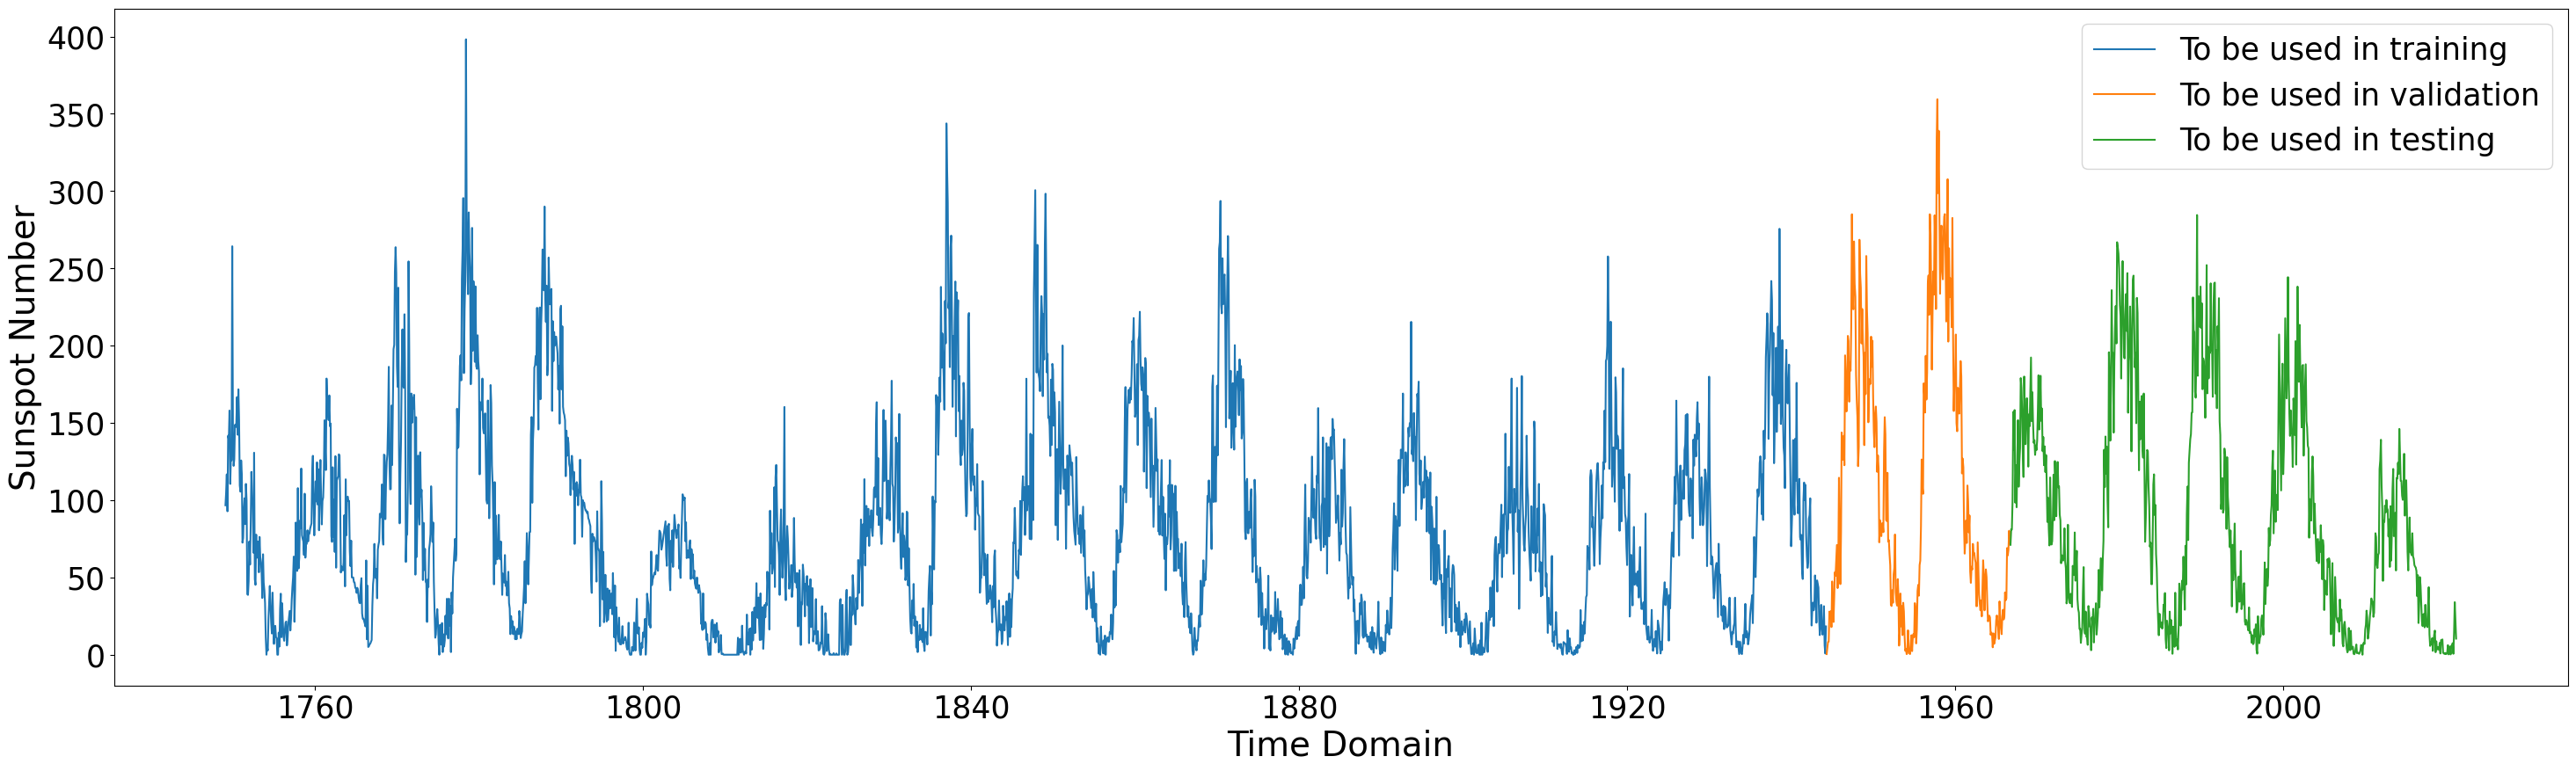

In [6]:
blue_part=df.iloc[:2343]
black_part=df.iloc[2343:2612]
red_part = df.iloc[2612:]

plt.figure(figsize=(36,10))
plt.plot(blue_part, label='To be used in training')
plt.plot(black_part, label='To be used in validation')
plt.plot(red_part, label='To be used in testing')
plt.xlabel('Time Domain')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()

In [7]:
print(df.iloc[2342])
print(df.iloc[2343])
print(df.iloc[2611])
print(df.iloc[2612])

Sunspot    18.3
Name: 1944-03-31 00:00:00, dtype: float64
Sunspot    0.4
Name: 1944-04-30 00:00:00, dtype: float64
Sunspot    72.6
Name: 1966-08-31 00:00:00, dtype: float64
Sunspot    71.1
Name: 1966-09-30 00:00:00, dtype: float64


## Breaking the dataset into train and test
We will keep some of the train data as validation data to check the performance of the models 

In [8]:
np.random.seed(42)
dataset = df.Sunspot.values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)
# LSTM is sensitive to scale, thus a scaler is necessary.
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

In [9]:
train, test = train_test_split(dataset, test_size=0.2, shuffle=False)

In [10]:
print(train.shape, test.shape)

(2612, 1) (653, 1)


In [11]:
def creat_dataset(data, prev=1):
    # To create the windowed dataset.
    # prev: How many previous timestamp's data will be used.
    dataX, dataY = [],[]
    for i in range(len(data) - prev -1):
        cache = data[i:(i+prev),0]
        dataX.append(cache)
        dataY.append(data[i+prev,0])
    return np.array(dataX), np.array(dataY)

In [12]:
prev_steps = 14
X_train,y_train = creat_dataset(train, prev_steps)
X_test, y_test = creat_dataset(test, prev_steps)
#reshape input into to be [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [13]:
# Set a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [14]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(2337, 1, 14) (260, 1, 14) (2337,) (260,)


## Model 

### Simple LSTM + Dense Model. 
This mmodel has a LSTM layer and two fully connected dense layers for prediction. Each output from the LSTM for each window is used as an input for The dense layer which then gives the output. 

In [15]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(LSTM(64,return_sequences=False, name="normal-lstm_2"))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError, metrics=[tf.keras.metrics.MeanAbsoluteError])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,449 (95.50 KB)

 Trainable params: 24,449 (95.50 KB)

 Non-trainable params: 0 (0.00 B)

### LSTM + Bayesian DenseVariational

This model uses a denseVaraitional layer. This layer uses variational inference to fit a "surrogate" posterior to the distribution over both the kernel matrix and the bias terms which are otherwise used in a manner similar to specify weights during training in gradient descent in Dense layers.

The layer fits the "weight posterior" :

$$[K,b] \sim \text{Prior}()$$ 
$$M = \text{matmul}(X,K) + b$$ 
$$Y \sim \text{Likelihood}(M)$$



In [16]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tfk.Sequential(
        [
            tfp.layers.VariableLayer(n),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1))
            )
        ]
    )
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    posterior_model = tfk.Sequential(
        [
            tfp.layers.VariableLayer(2*n),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                tfd.Normal(loc=t[...,:n],
                           scale=1e-5 + tf.nn.softplus(c + t[...,n:])))
            )
        ]
    )
    return posterior_model

In [17]:
variational_model = tfk.Sequential([
    tfkl.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    tfpl.DenseVariational(
                    units=64,
                    make_prior_fn=prior,
                    make_posterior_fn=posterior,
                    kl_weight=1 / train.shape[0]
                ),
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
    tfkl.Dense(64, activation='relu'),
    tfkl.Dense(1)
])

variational_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
variational_model.summary()


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 dense_variational (DenseVa  (None, 64)                12480     
 riational)                                                      
                                                                 
 distribution_lambda (Distr  ((None, 64),              0         
 ibutionLambda)               (None, 64))                        
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                   

### Training the models


In [18]:
# adding early stopping to avoid overfitting
# es = EarlyStopping(monitor='val_loss', min_delta = 0, verbose=0, patience=10, mode='auto')

In [19]:
history = model.fit(X_train, y_train, 
                    batch_size=16, 
                    epochs=100, 
                    validation_data=(X_valid,y_valid), 
                    # callbacks=[es]
                   )

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.4157 - mean_absolute_error: 0.4718 - val_loss: 0.2324 - val_mean_absolute_error: 0.3464
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1381 - mean_absolute_error: 0.2695 - val_loss: 0.1691 - val_mean_absolute_error: 0.2971
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1575 - mean_absolute_error: 0.2809 - val_loss: 0.1704 - val_mean_absolute_error: 0.2986
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1403 - mean_absolute_error: 0.2643 - val_loss: 0.1732 - val_mean_absolute_error: 0.3047
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1367 - mean_absolute_error: 0.2665 - val_loss: 0.1940 - val_mean_absolute_error: 0.3088
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1319 - mean_absolute_error: 0.2620 - val_loss: 0.1902 - val_mean_absolute_error: 0.3095
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1352 - mean_absolute_error: 0.

In [20]:
# es1 = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, verbose=0, patience=10, mode='auto')

In [21]:
variational_history = variational_model.fit(X_train, y_train, 
                                            batch_size=16, 
                                            epochs=100, 
                                            validation_data=(X_valid,y_valid), 
                                            # callbacks=[es1]
                                           )

Epoch 1/100

147/147 [==============================] - 11s 21ms/step - loss: 1.4219 - mae: 0.9247 - val_loss: 1.2748 - val_mae: 0.8884
Epoch 2/100
147/147 [==============================] - 1s 8ms/step - loss: 0.7527 - mae: 0.6733 - val_loss: 0.7446 - val_mae: 0.6721
Epoch 3/100
147/147 [==============================] - 1s 8ms/step - loss: 0.5950 - mae: 0.6009 - val_loss: 0.5222 - val_mae: 0.5604
Epoch 4/100
147/147 [==============================] - 1s 8ms/step - loss: 0.5143 - mae: 0.5532 - val_loss: 0.5244 - val_mae: 0.5479
Epoch 5/100
147/147 [==============================] - 1s 8ms/step - loss: 0.4629 - mae: 0.5279 - val_loss: 0.8375 - val_mae: 0.6609
Epoch 6/100
147/147 [==============================] - 1s 8ms/step - loss: 0.4036 - mae: 0.4828 - val_loss: 0.5590 - val_mae: 0.5851
Epoch 7/100
147/147 [==============================] - 1s 8ms/step - loss: 0.3462 - mae: 0.4484 - val_loss: 0.3838 - val_mae: 0.4882
Epoch 8/100
147/147 [==============================] - 1s 8ms/step

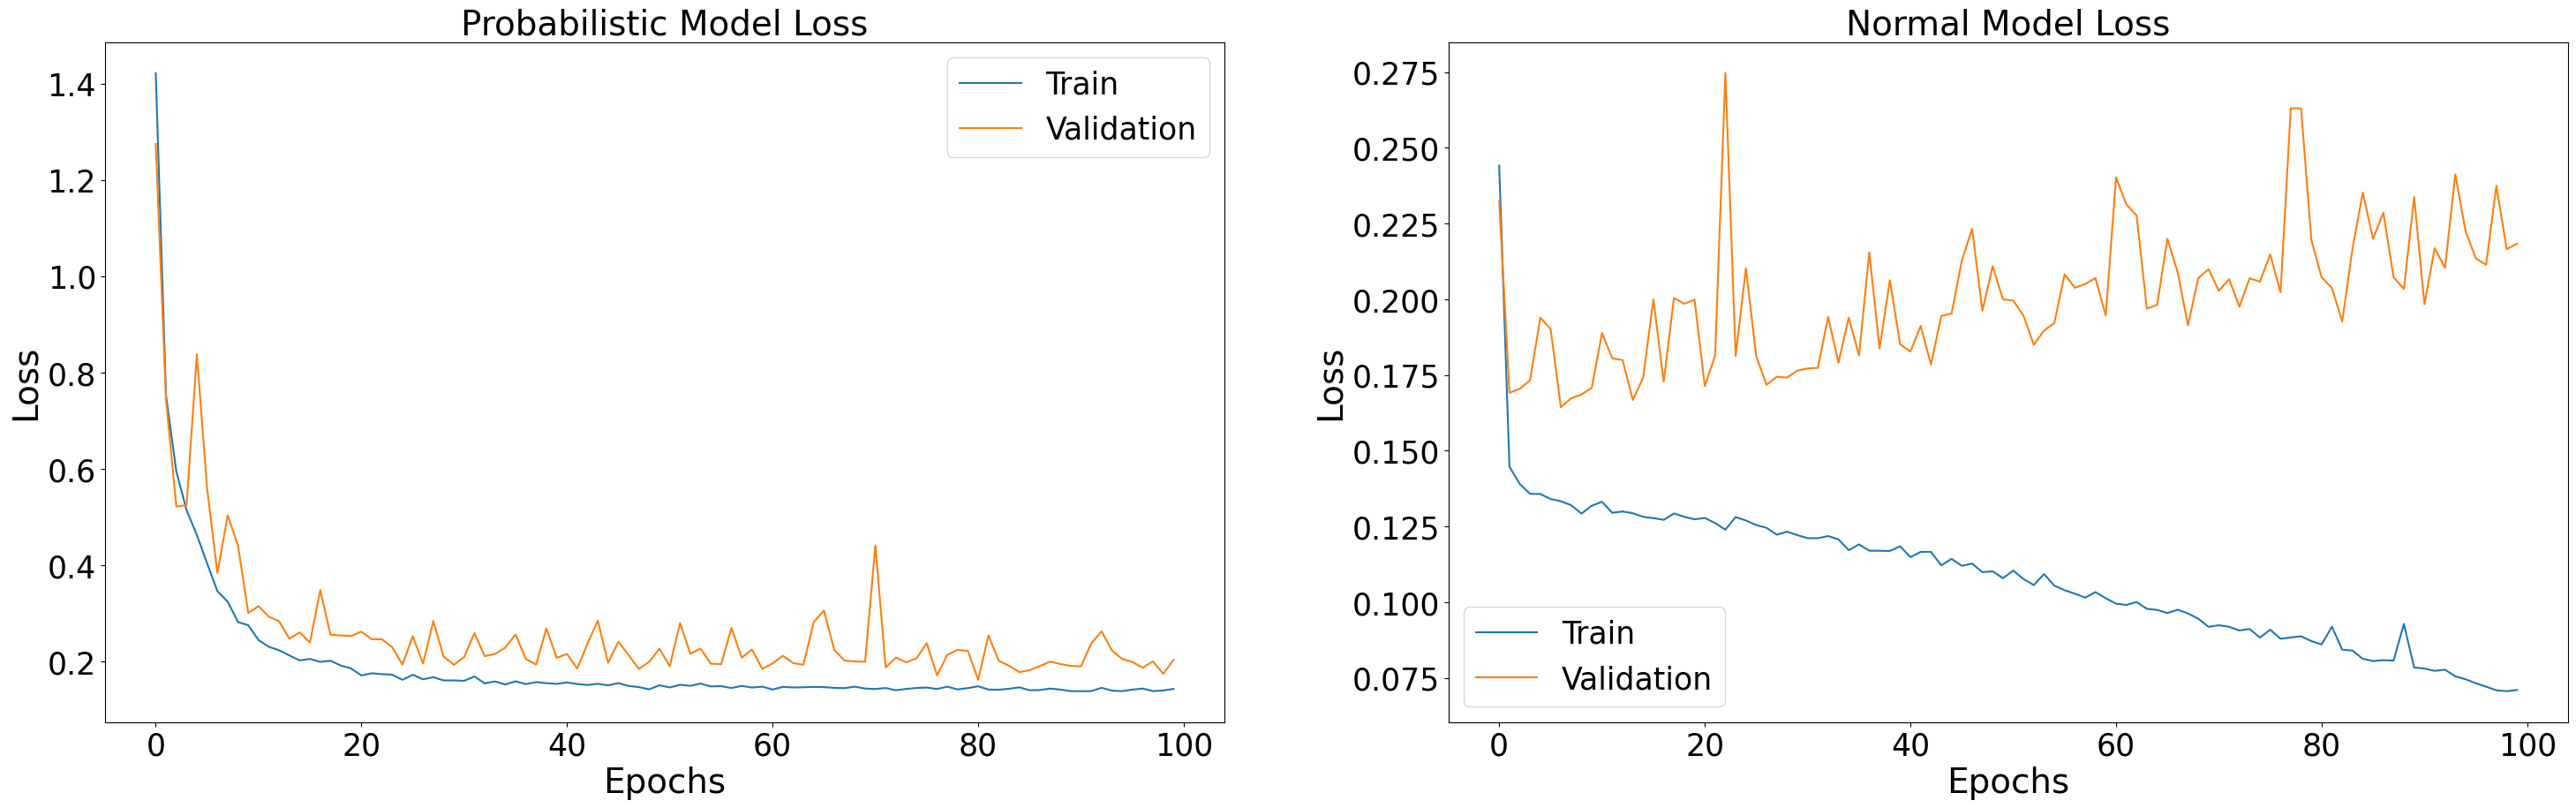

In [22]:
## Train and validation loss plots

fig, axs = plt.subplots(1,2, figsize=(36,10))

axs[0].plot(variational_history.history['loss'], label='Train')
axs[0].plot(variational_history.history['val_loss'], label='Validation')
axs[0].set_title("Probabilistic Model Loss")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['loss'], label='Train')
axs[1].plot(history.history['val_loss'], label='Validation')
axs[1].set_title("Normal Model Loss")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

## Predicting and checking with actual data

In [23]:
test_error = []
for i in range(100):
    normal_prediction = scaler.inverse_transform(model.predict(X_test))
    test_error.append(mean_absolute_error(y_test, normal_prediction))

print(f"Test error: {np.mean(np.array(test_error))}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━

We are running the model a 100 to gather the **mean** and **standard deviation** of the model predictions

In [24]:
variational_predictions = []
var_test_error = []
for i in range(100):
    variational_prediction = scaler.inverse_transform(variational_model.predict(X_test))
    variational_predictions.append(variational_prediction)
    var_error = mean_absolute_error(y_test, variational_prediction)
    var_test_error.append(var_error)

print(f"Test error: {np.mean(np.array(var_test_error))}")

20/20 [==============================] - 0s 5ms/step
Test error: 84.30489448547364


In [25]:
variational_predictions = np.array(variational_predictions)
mean_variational_predictions = np.mean(variational_predictions, axis=0).flatten()
std_variational_predictions = np.std(variational_predictions, axis=0).flatten()

# print(mean_variational_predictions)

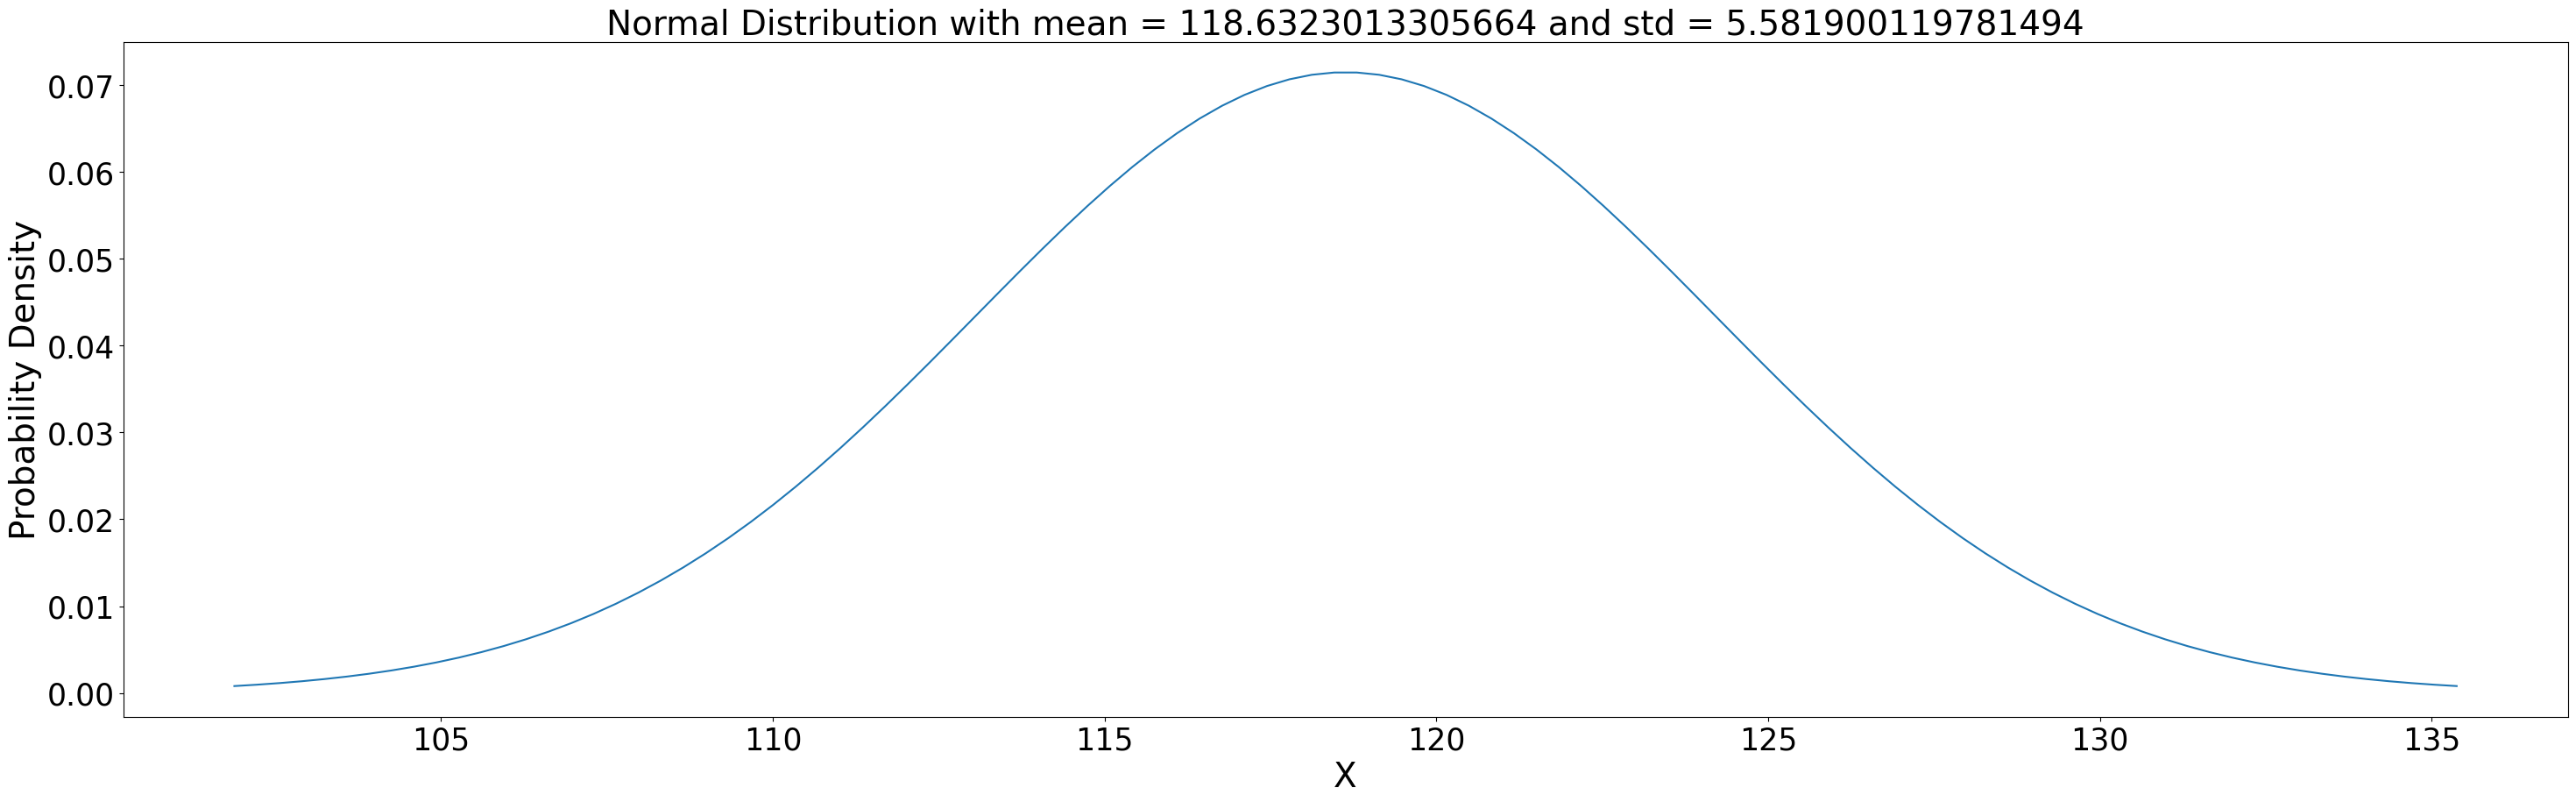

In [26]:
from scipy.stats import norm
mu = mean_variational_predictions[0]
sigma = std_variational_predictions[0]
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

# Plotting the graph
plt.figure(figsize=(36,10))
plt.plot(x, y)

plt.title(f'Normal Distribution with mean = {mu} and std = {sigma}')
plt.xlabel('X')
plt.ylabel('Probability Density')

plt.show()

Text(0.5, 1.0, 'Sunspot pred')

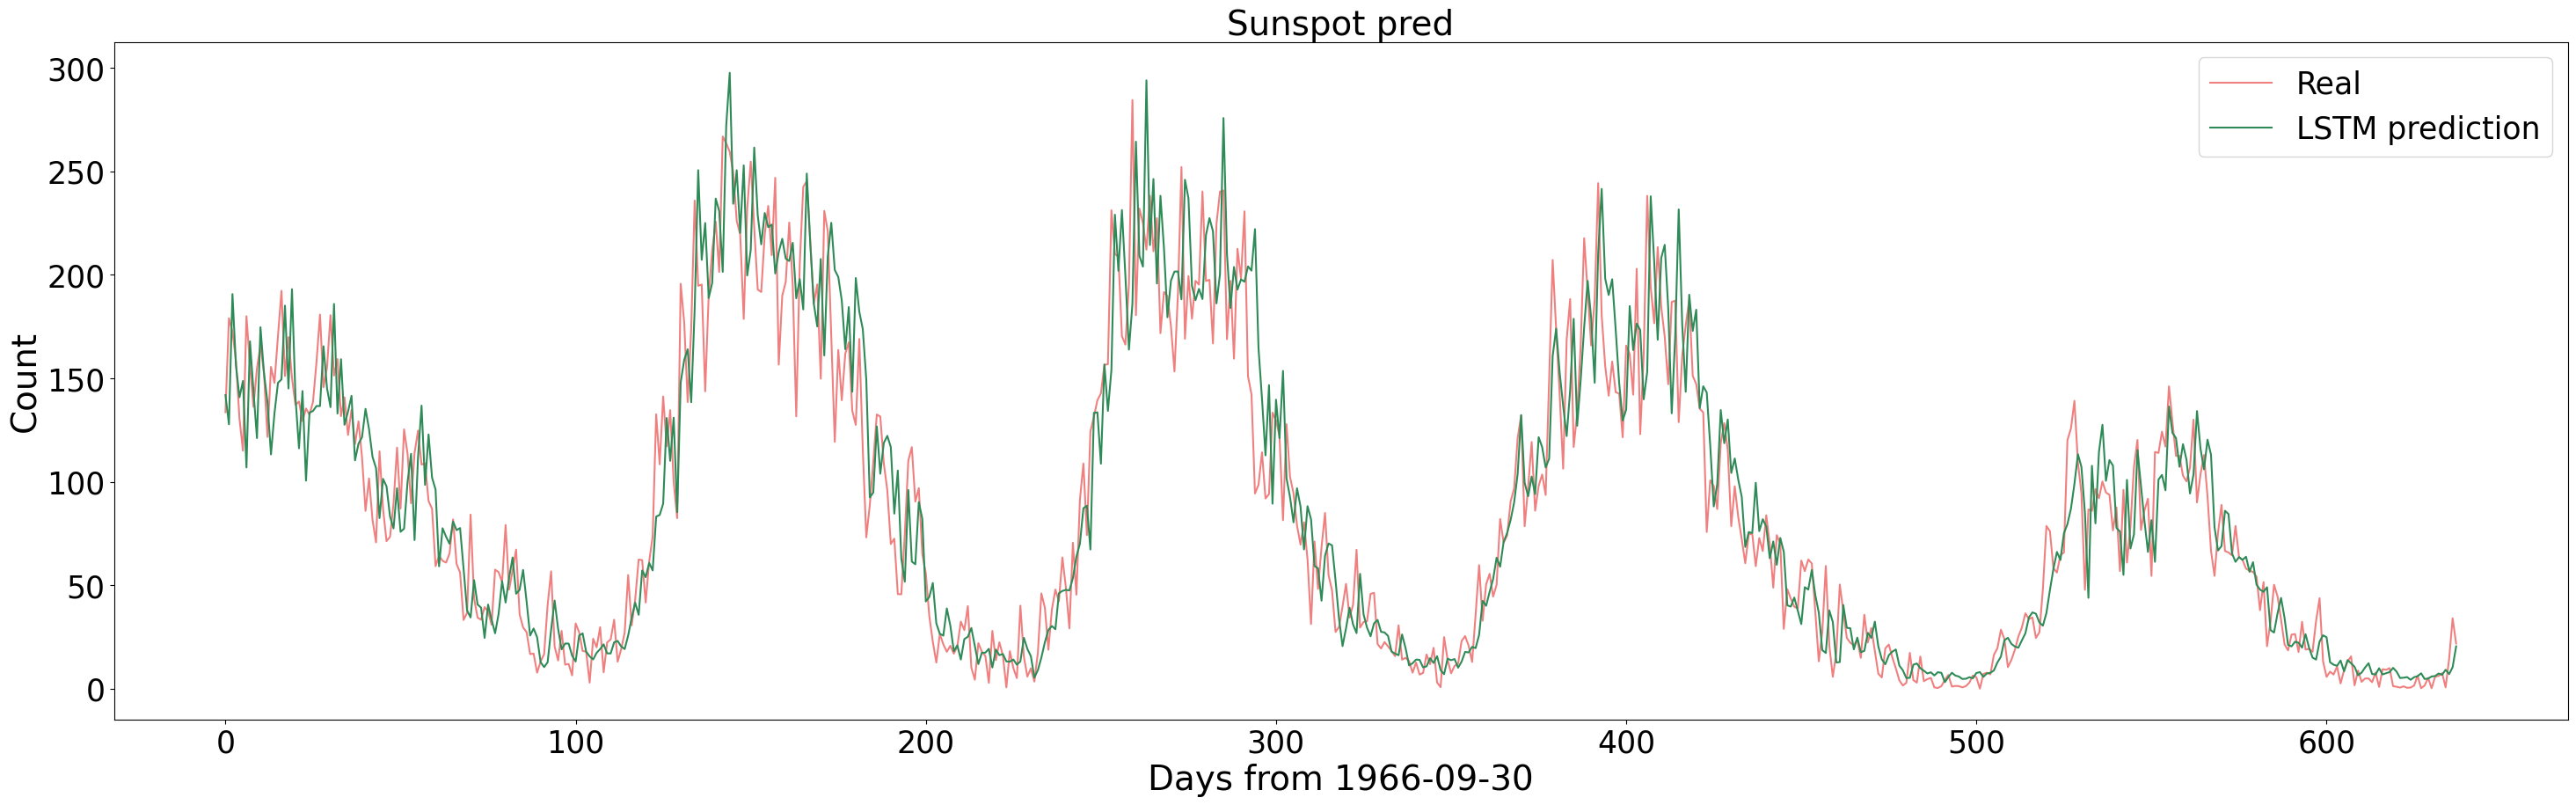

In [27]:
plt.figure(figsize=(36,10))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='Real', color='lightcoral')
plt.plot(normal_prediction, label='LSTM prediction', color='seagreen')
# plt.plot(variational_predictions, label='Bayesian')
plt.ylabel("Count")
plt.xlabel("Days from 1966-09-30")
plt.legend()
plt.title('Sunspot pred')

In [28]:
print(df.iloc[2962])
print(df.iloc[3062])

Sunspot    14.0
Name: 1995-11-30 00:00:00, dtype: float64
Sunspot    74.8
Name: 2004-03-31 00:00:00, dtype: float64


Text(0.5, 1.0, 'Sunspot pred')

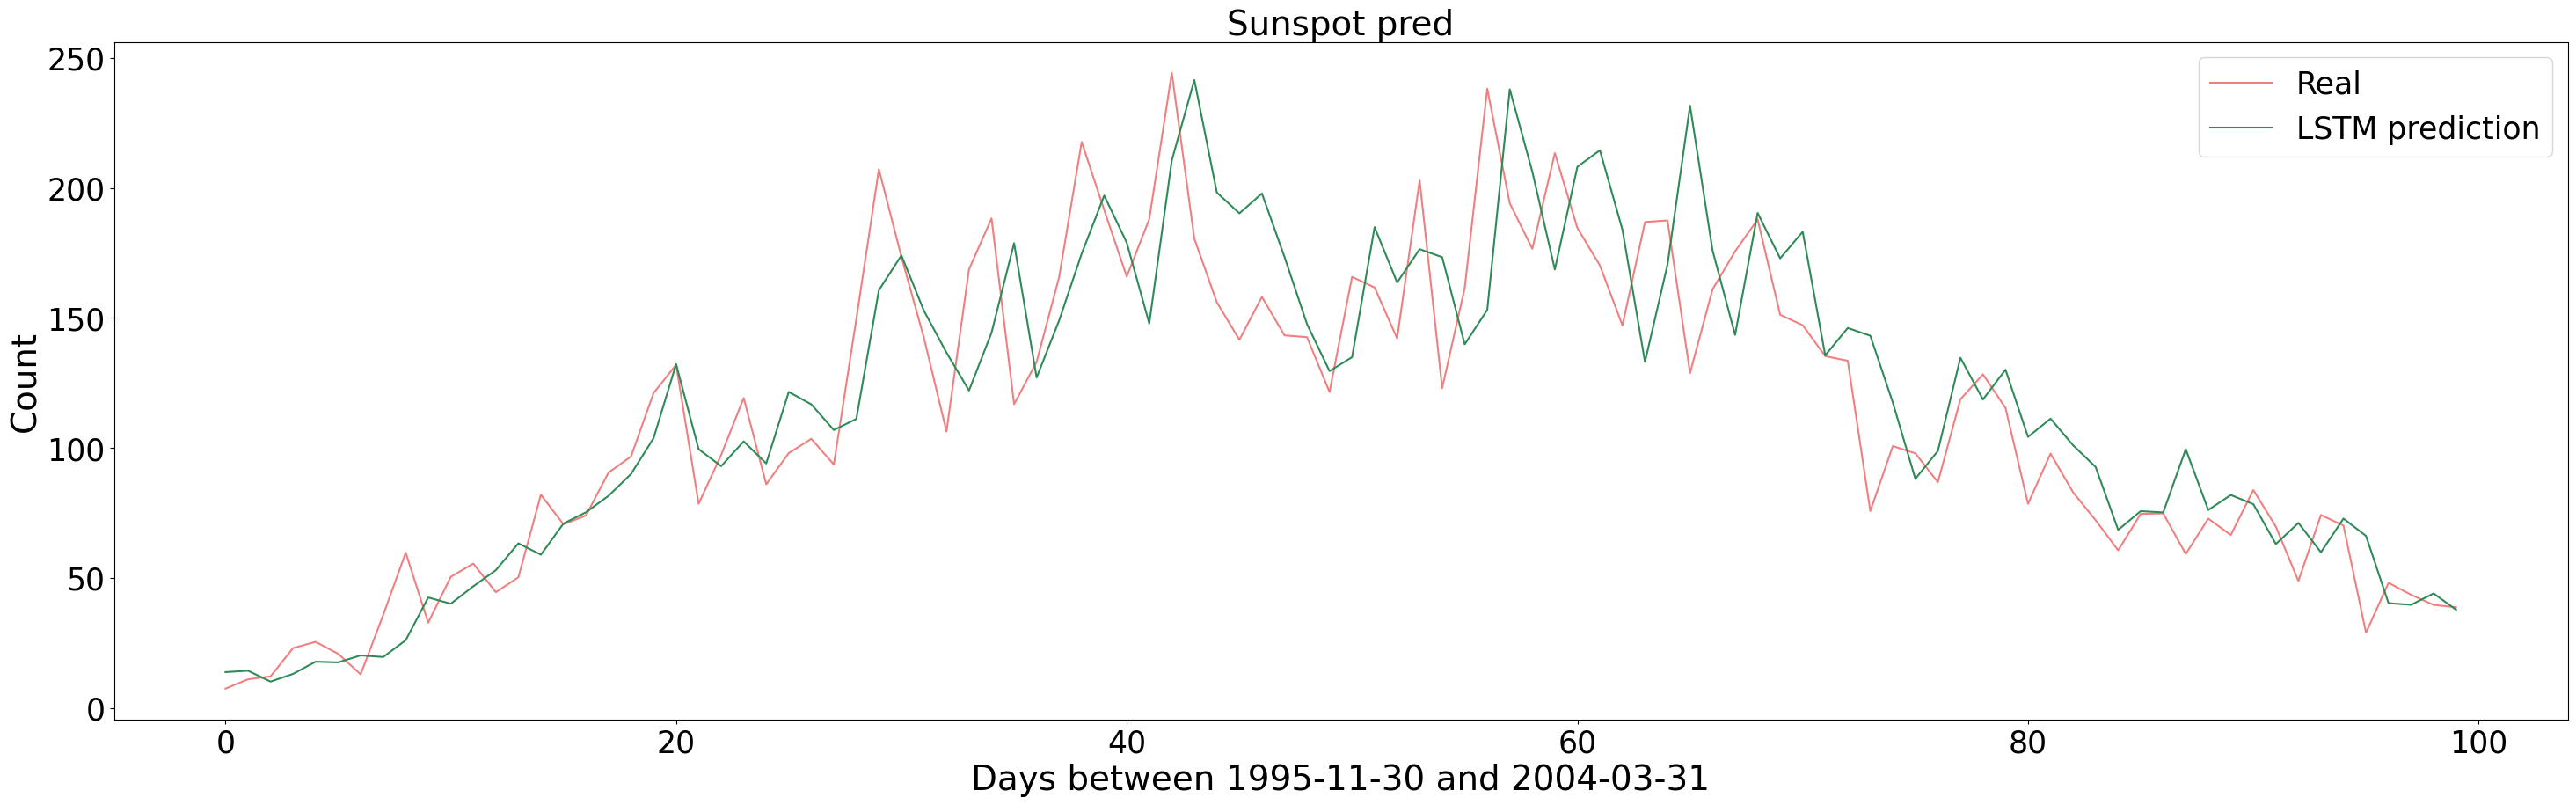

In [29]:
plt.figure(figsize=(36,10))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1))[350:450], label='Real', color='lightcoral')
plt.plot(normal_prediction[350:450], label='LSTM prediction', color='seagreen')
# plt.plot(variational_predictions, label='Bayesian')
plt.ylabel("Count")
plt.xlabel("Days between 1995-11-30 and 2004-03-31")
plt.legend()
plt.title('Sunspot pred')

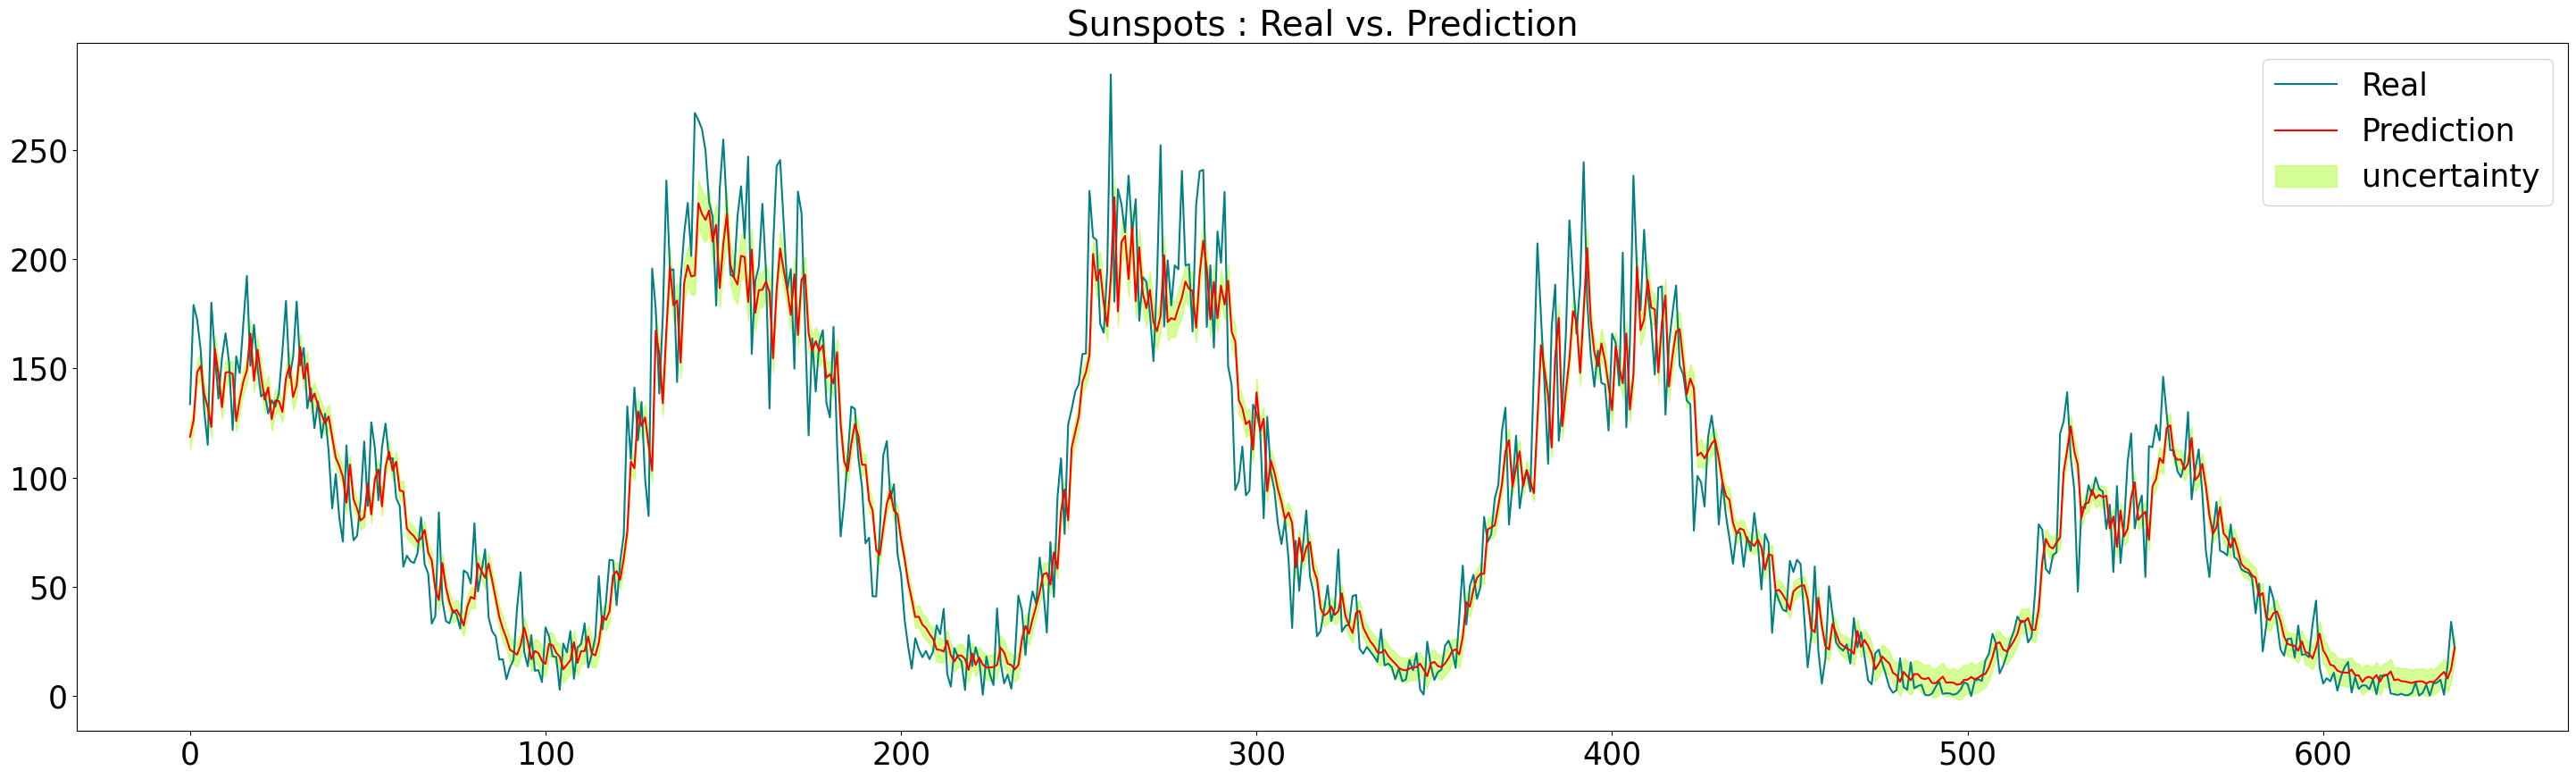

In [30]:
plt.figure(figsize=(36,10))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)) , label='Real', color='teal')
plt.plot(mean_variational_predictions , label='Prediction', color='red')
# plt.plot(mean_variational_predictions + std_variational_predictions, label='Prediction + STD', alpha=0.5, color='purple')
# plt.plot(mean_variational_predictions - std_variational_predictions, color='darkgreen', label='Prediction - STD', alpha=0.5)
plt.fill_between(range(len(y_test)), mean_variational_predictions - std_variational_predictions, mean_variational_predictions + std_variational_predictions, color='greenyellow', alpha=0.5, label='uncertainty')
plt.title('Sunspots : Real vs. Prediction')
plt.legend()